In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, filtfilt
import scipy
#from PyEMD import EMD
import time
from scipy.signal import medfilt
from scipy.signal import firwin, lfilter
import pywt
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

from utils import print_signal_qrs, print_signal, calcul_f1, perf

In [3]:
def highpass_filter(data, 5, fs, order=5):
    nyquist = 0.5 * fs
    high = cutoff / nyquist
    b, a = butter(order, high, btype='high')
    y = filtfilt(b, a, data)
    return y

def lowpass_filter(data, 15, fs, order=5):
    nyquist = 0.5 * fs
    low = cutoff / nyquist
    b, a = butter(order, low, btype='low')
    y = filtfilt(b, a, data)
    return y

def differentiate(data):
    return np.diff(data, prepend=data[0])

def squaring(data):
    return np.square(data)

def moving_window_integration(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def preprocess_ecg(data, fs, low, up):
    high_passed_data = highpass_filter(data, up, fs)
    low_passed_data = lowpass_filter(high_passed_data, low, fs)
    differentiated_data = differentiate(low_passed_data)
    squared_data = squaring(differentiated_data)
    integrated_data = moving_window_integration(squared_data, int(0.0667 * fs))  # window size of 66.7 ms
    return integrated_data

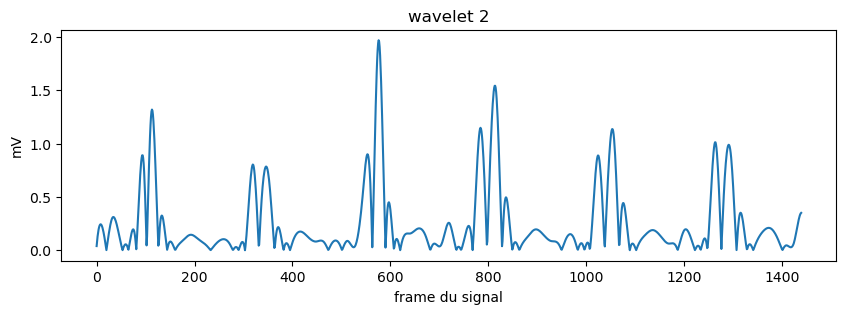

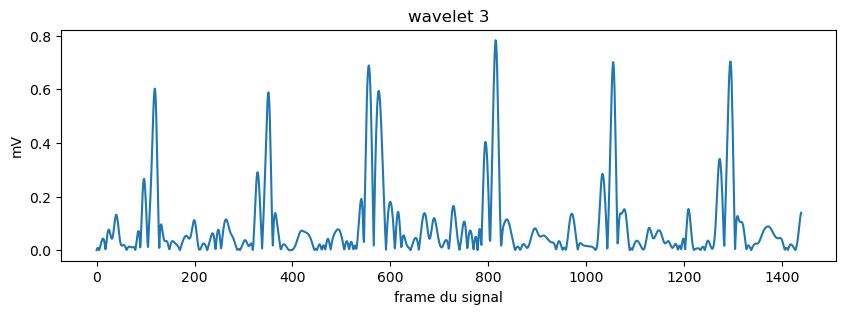

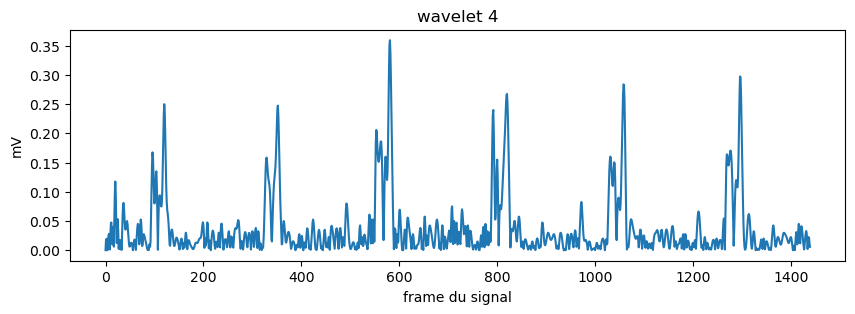

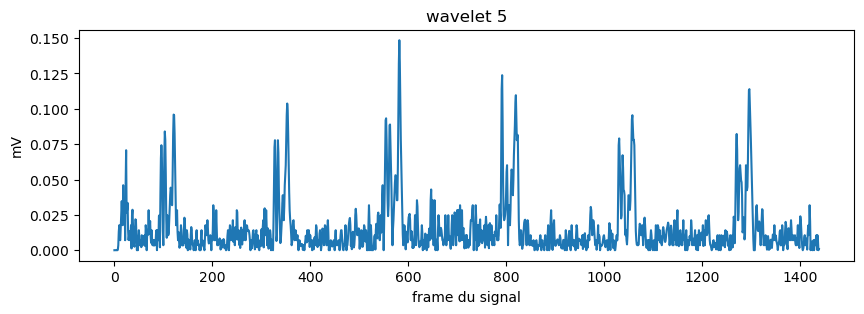

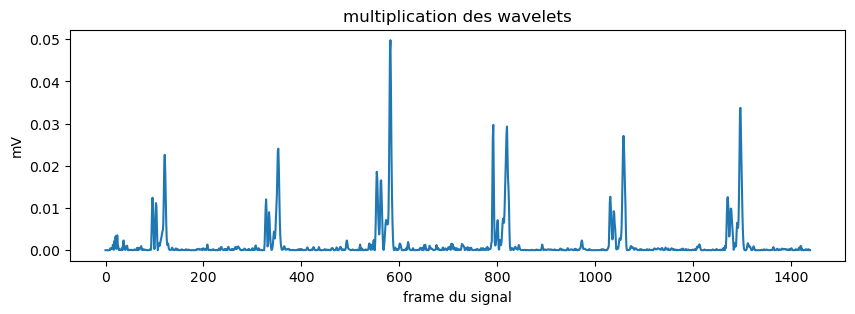

In [18]:
def upsample_signal(original_signal, upsampled_length):
    # Coordonnées originales du signal
    original_indices = np.linspace(0, len(original_signal) - 1, num=len(original_signal))
    
    # Coordonnées désirées du signal upsampled
    upsampled_indices = np.linspace(0, len(original_signal) - 1, num=upsampled_length)
    
    # Interpolation spline cubique
    cs = CubicSpline(original_indices, original_signal)
    #interp1d(upsampled_indices, upsampled_indices, kind = 'zero')
    
    # Signal upsampled
    upsampled_signal = cs(upsampled_indices)
    
    return upsampled_signal

def wavelet_decomposition(sig, idx):
    # Décomposition en ondelettes
    coeffs = pywt.wavedec(sig, "haar", level=idx)
    # Prendre les coefficients aux niveaux idx-4 et idx-5
    w2 = coeffs[-4]
    w3 = coeffs[-3]
    w4 = coeffs[-2]
    w5 = coeffs[-1]

    # Upsample les coefficients à la longueur du signal original
    w2_upsampled = upsample_signal(w2, len(sig))
    w3_upsampled = upsample_signal(w3, len(sig))
    w4_upsampled = upsample_signal(w4, len(sig))
    w5_upsampled = upsample_signal(w5, len(sig))

    print_signal(np.abs(w2_upsampled[:1440]), 'wavelet 2')
    print_signal(np.abs(w3_upsampled[:1440]), 'wavelet 3')
    print_signal(np.abs(w4_upsampled[:1440]), 'wavelet 4')
    print_signal(np.abs(w5_upsampled[:1440]), 'wavelet 5')

    
    # Multiplication des coefficients upsampled et prise de la valeur absolue
    resultat = np.abs(w4_upsampled * w5_upsampled)
    
    return resultat

h = wavelet_decomposition(ecg_signal, 6)
print_signal(h[:1440], "multiplication des wavelets")

signal de longueur: 1440


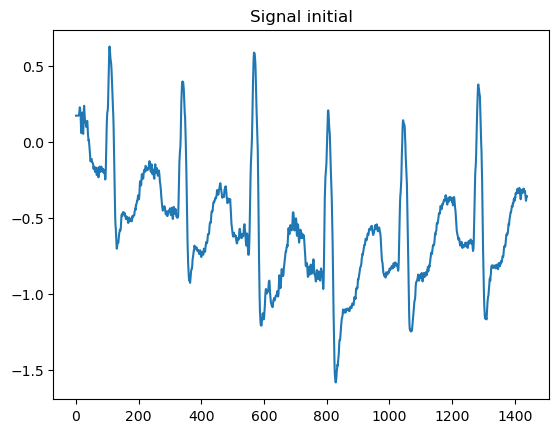

In [97]:
print_signal(ecg_signal[:1440], "Signal initial")

In [112]:
162500/650000

0.25

In [6]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/109.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:1000]
fs = 360  # Example sampling frequency
QRS = df["labels"].dropna().astype(int).tolist()

In [7]:
def print_signal(signal, description= "A"):
    plt.figure(figsize = (10, 3))
    plt.plot(signal)
    plt.title(label= description)
    plt.xlabel('frame du signal')
    plt.ylabel("mV")
    plt.show()

In [8]:
360*4

1440

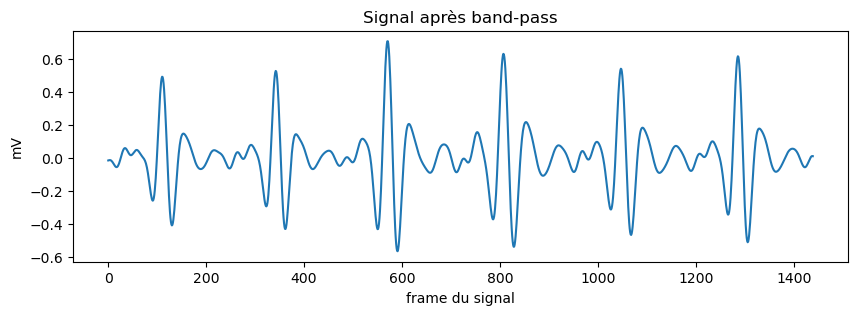

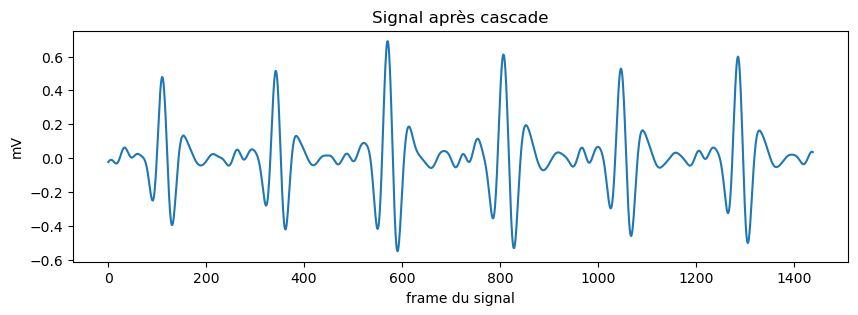

In [14]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

band_passed_data = bandpass_filter(ecg_signal, 5, 15, fs)

print_signal(band_passed_data[:1440], "Signal après band-pass")
print_signal(low_passed_data[:1440], "Signal après cascade")


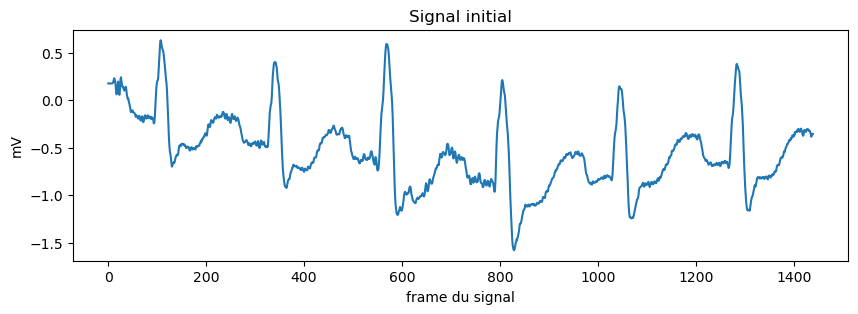

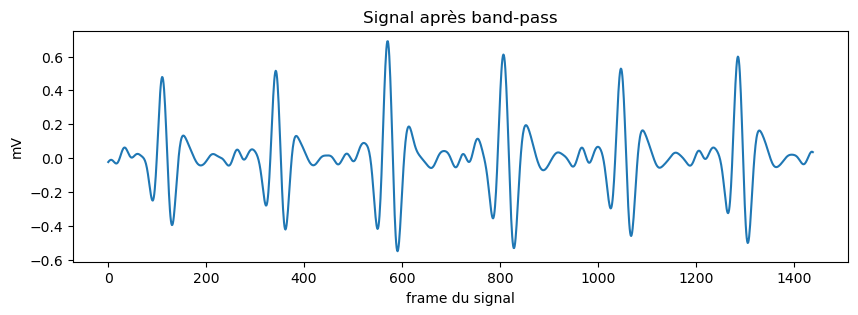

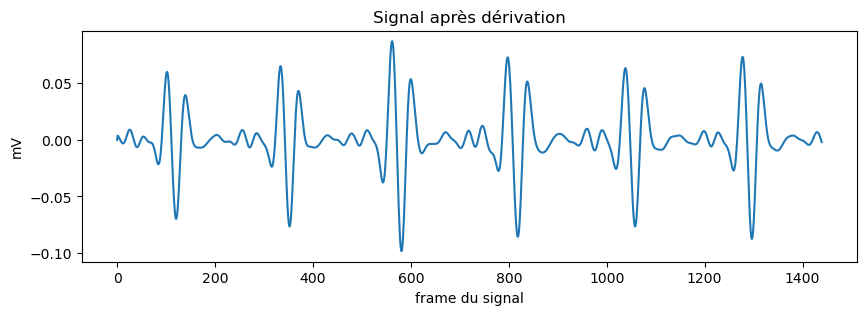

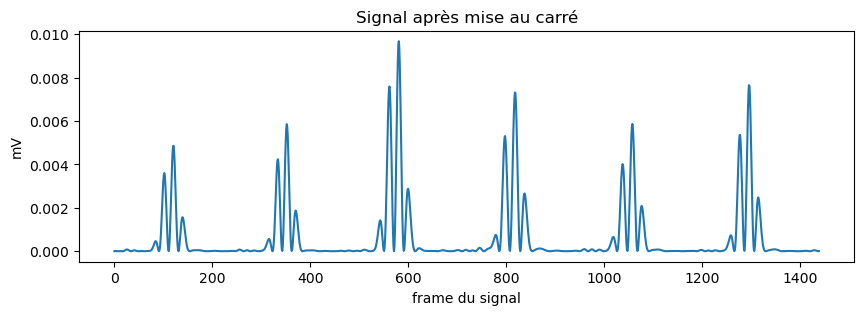

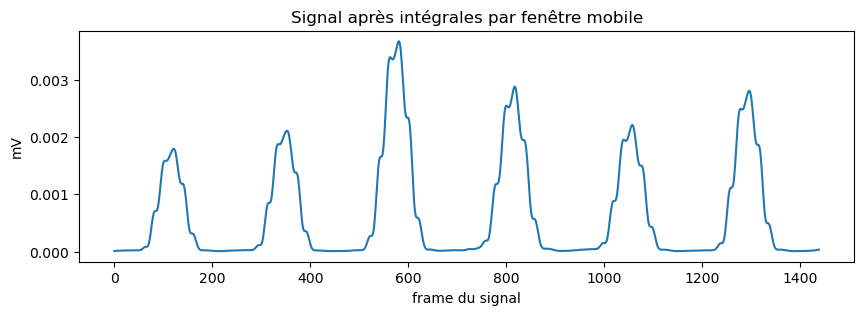

In [10]:
print_signal(ecg_signal[:1440], "Signal initial")
high_passed_data = highpass_filter(ecg_signal, 5, fs)
low_passed_data = lowpass_filter(high_passed_data, 15, fs)
print_signal(low_passed_data[:1440], "Signal après band-pass")
differentiated_data = differentiate(low_passed_data)
print_signal(differentiated_data[:1440], "Signal après dérivation")
squared_data = squaring(differentiated_data)
print_signal(squared_data[:1440], "Signal après mise au carré")
integrated_data = moving_window_integration(squared_data, int(0.15 * fs))  # window size of 66.7 ms
print_signal(integrated_data[:1440], "Signal après intégrales par fenêtre mobile")

In [6]:
def print_signal_qrs(signal, qrs, mini = 0, maxi = 1, description = "a"):
    if maxi == 1:
        maxi = len(signal)
    cut_qrs = [a - mini for a in qrs if a < maxi and a > mini]
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    signal_cut = signal[mini:maxi]
    plt.plot(signal_cut)
    plt.scatter(cut_qrs , [signal_cut[i] * 1.05 for i in cut_qrs ], color='blue', label = 'predicted')
    plt.title(label= description)
    plt.legend()
    plt.show()

In [42]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:1000]
fs = 360  # Example sampling frequency
QRS = df["labels"].dropna().astype(int).tolist()
qrs, M_list, R_list = multi_lvl(ecg_signal, fs)
cleaned_ecg = preprocessing(ecg_signal, fs)

In [43]:
L, P = qrs_detector_5(cleaned_ecg, fs)

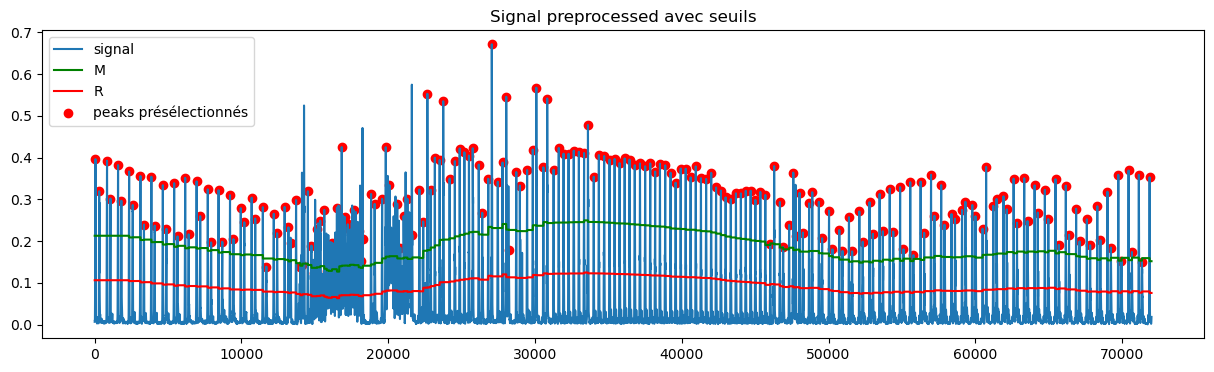

In [44]:
plt.figure(figsize=(15, 4))
taille = int(fs*200)
peakos = [a for a in L if a <= taille]
cut_ecg = cleaned_ecg[:taille]
plt.plot(cut_ecg, label = "signal")
#plt.plot(NPK[:taille], label = "valeur de NPK")
#plt.plot(SPK[:taille], label = "valeur de SPK", color = "pink")

plt.plot(M_list[:taille], label = "M", color="green")
plt.plot(R_list[:taille], label = "R", color="red")

plt.scatter(peakos, [cut_ecg[i] for i in peakos], color='red', label = 'peaks présélectionnés')
#plt.scatter(final_peakos, [cut_ecg[i]* 1.05 for i in final_peakos], color='black', label = 'peaks finaux', s=[100]*len(final_peakos))
plt.title(label= "Signal preprocessed avec seuils")
plt.legend(loc = 'upper left')
plt.show()

In [30]:
def multi_lvl(ecg_signal, fs):
    clean_signal = preprocessing(ecg_signal, fs)
    L, P = qrs_detector_5(clean_signal, fs)
    T = sum(P) / len(P)
    M = T.copy()
    R = T * 0.6

    Vsl = M
    Vnl = R

    Bw = 0

    i = 6
    H = L[:6]
    G = P[:6]
    B_i = 0
    list_M = []
    list_R = []
    previous = 0
    while i < len(P):
        if P[i] >= M:
            G.append(P[i])
            H.append(L[i])
            Vsl = make_vsl(P[i] , Vsl)

        elif P[i] < M and P[i] >= R:
            B_i = make_B_i(H, fs, len(H)-2)
            Bw = make_Bw(B_i, len(H)-1, H, fs)

            if B_i <= Bw:
                G.append(P[i])
                H.append(L[i])
                Vsl = make_vsl(P[i] , Vsl) 
            else:
                Vnl = make_vnl(P[i], Vnl)
                
        M = make_M(Vnl, Vsl)
        R = M/2
        list_M.extend([M] * (L[i] - previous))
        list_R.extend([R] * (L[i] - previous))
        previous = L[i]
        i += 1

    C = 50000
    G_seg, H_seg = divide_into_segments(G, H, C)
    i = 1
    while i < len(G_seg):
        Y = H_seg[i]
        Z = G_seg[i]
        F = 0.8 * sum(Z) / C
        Dfp = make_Dfp(Y)
        k = 0.95 # à voir
        W = k * sum(Dfp) / len(Dfp)
        for idx, zi in enumerate(Z):
            if zi < F and Dfp[idx-1] < W and Dfp[idx] < W:
                Y.pop(idx)
                Z.pop(idx)
        i += 1
    A = [element for sous_liste in H_seg for element in H_seg][0]
    E = [element for sous_liste in H_seg for element in G_seg][0]
    Dsb =  [A[x] - A[x-1] for x in range(1, len(A))]
    S = 1.75 * sum(Dsb) / len(Dsb)
    n = 1
    Q = len(Dsb)
    final_peaks = []
    while n < Q:
        if Dsb[n] >= S:
            sub_signal = clean_signal[A[n]:A[n+1]+1]
            M_local = max(sub_signal) * 0.25
            f = qrs_detector_5(sub_signal, fs, seuil = M_local, delay = S/2)
            final_peaks.extend(f[0][1:])
        final_peaks.append(A[n])
        n += 1
    return final_peaks, list_M, list_R

def make_B_i(H, fs, i):
    return (60 * fs) / (H[i+1] - H[i])

def make_Bw(B_i, Q, H, fs):
    return 1.75 * sum([make_B_i(H, fs, i) for i in range(3, Q-1)]) / (Q - 4) 

def make_vsl(a, vsl):
    return a * 0.1 + 0.9 * vsl

def make_vnl(a, vnl):
    return 0.2 * a + 0.8 * vnl

def make_M(Vnl, Vsl):
    return 0.6 * Vnl + (0.6 * (Vsl - Vnl))

def divide_into_segments(G, H, C):
    G_segments = [G[i:i+C] for i in range(0, len(G), C)]
    H_segments = [H[i:i+C] for i in range(0, len(H), C)]
    return G_segments, H_segments

def make_Dfp(Y):
    return [Y[x] - Y[x-1] for x in range(1, len(Y))]

def preprocessing(ecg_signal, fs):
    band_pass_filter = scipy.signal.butter(1, [5, 35], btype='bandpass', fs=fs)
    filtered_signal = scipy.signal.filtfilt(band_pass_filter[0], band_pass_filter[1], ecg_signal)
    
    absolute_signal = np.abs(filtered_signal)
    window_length = int(0.05 * fs)
    smoothed_signal = np.convolve(absolute_signal, np.ones(window_length)/window_length, mode='same')
    
    return smoothed_signal

def qrs_detector_5(signal, fs, seuil = 0, delay = 0):
    if seuil == 0:
        seuil = max(signal) / 6
    if delay == 0: 
        delay = fs//10
    i = 0
    peak_position = []
    peak_amplitude = []
    sous_groupe = []
    while i < len(signal):
        if signal[i]>= seuil:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= delay:
            max_value = max((signal[j], j) for j in sous_groupe)
            peak_amplitude.append(max_value[0])
            peak_position.append(max_value[1])
            sous_groupe = []
            i += int(fs * 0.28) # interval minimum donné dans l'article
        i += 1
    if sous_groupe != []:
        max_value = max((signal[j], j) for j in sous_groupe)
        peak_amplitude.append(max_value[0])
        peak_position.append(max_value[1])
    return peak_position, peak_amplitude


def qrs_detector_wow(signal, fs):
    peak_position = seuil_dynamique(signal, fs)
    peak_amplitude = [signal[i] for i in peak_position]
    return peak_position.tolist(), peak_amplitude


In [11]:
cleaned_ecg = preprocess_ecg(ecg_signal, fs, 15, 5)

In [ ]:
df.sort_values('f1')

In [ ]:
x = 500
t = range(x)

plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(t, ecg_signal[:x])
plt.title('Original ECG Data')
plt.subplot(2, 1, 2)
plt.plot(t, cleaned_ecg[:x])
plt.title('Processed ECG Data')
plt.show()

In [5]:
def make_SPK(m_val):
    # SPK = 0.13 * M_VAL
    return 0.13 * m_val

def make_NPK(spk):
    # NPK = 0.1 * SPK
    return 0.1 * spk

def calcul_seuil(spk, npk):
    # SEUIL = 0.25 * SPK + 0.75 * NPK
    return 0.25 * spk + 0.75 * npk

def calcul_AVE_RR(list_frames):
    return sum(np.diff(list_frames[-10:]))/len(list_frames)

In [1]:
360 * 0.15

54.0

In [6]:
def detect_peaks(cleaned_ecg, distance=int(fs*0.15), no_peak_distance=300):

    last_max = -np.inf  # The most recent encountered maximum value
    last_max_pos = -1  # Position of the last_max in the array
    peaks = []  # Detected peaks positions
    peak_values = []  # Detected peaks values
    
    for i in range(len(cleaned_ecg)):
        current_value = cleaned_ecg[i]
        
        if current_value > last_max:
            last_max = current_value
            last_max_pos = i
        
        if current_value <= last_max / 2 or (i - last_max_pos >= no_peak_distance and last_max_pos != -1):
            if last_max_pos != -1:
                peaks.append(last_max_pos)
                peak_values.append(last_max)
            
            last_max = current_value
            last_max_pos = i
    
    peaks = np.array(peaks)
    peak_values = np.array(peak_values)
    
    refined_peaks = []
    i = 0
    while i < len(peaks):
        peak_group_start = i
        while i < len(peaks) - 1 and peaks[i + 1] - peaks[peak_group_start] < distance:
            i += 1
        peak_group_end = i
        
        if peak_group_start == peak_group_end:
            refined_peaks.append(peaks[i])
        else:
            # Select the peak with the maximum value in this group
            max_peak = peak_values[peak_group_start:peak_group_end+1].argmax()
            refined_peaks.append(peaks[peak_group_start + max_peak])
        
        i += 1
    
    return np.array(refined_peaks)

peaks = detect_peaks(cleaned_ecg)

In [7]:
def threshold_detection(cleaned_ecg, peaks, fs, initial_search_samples=300, long_peak_distance=400):
    M_VAL = np.max(cleaned_ecg[:initial_search_samples])
    
    SPK = 0.13 * M_VAL
    NPK = 0.1 * SPK
    THRESHOLD = 0.25 * SPK + 0.75 * NPK
    
    qrs_peaks = []
    noise_peaks = []
    qrs_buffer = []
    last_qrs_time = 0
    min_distance = int(fs * 0.33)
    
    for peak in peaks:
        peak_value = cleaned_ecg[peak]
        
        if peak_value > THRESHOLD:
            if qrs_peaks and (peak - qrs_peaks[-1] < min_distance):
                if peak_value > cleaned_ecg[qrs_peaks[-1]]:
                    qrs_peaks[-1] = peak
            else:
                qrs_peaks.append(peak)
                last_qrs_time = peak
            
            SPK = 0.25 * peak_value + 0.75 * SPK
            
            qrs_buffer.append(peak)
            if len(qrs_buffer) > 10:
                qrs_buffer.pop(0)
        else:
            noise_peaks.append(peak)
            NPK = 0.25 * peak_value + 0.75 * NPK
        
        THRESHOLD = 0.25 * SPK + 0.75 * NPK
        
        if peak - last_qrs_time > long_peak_distance:
            SPK *= 0.5
            THRESHOLD = 0.25 * SPK + 0.75 * NPK
            for lookback_peak in peaks:
                if last_qrs_time < lookback_peak < peak:
                    if cleaned_ecg[lookback_peak] > THRESHOLD:
                        qrs_peaks.append(lookback_peak)
                        SPK = 0.875 * SPK + 0.125 * cleaned_ecg[lookback_peak]
                        THRESHOLD = 0.25 * SPK + 0.75 * NPK
                        last_qrs_time = lookback_peak
                        break
        
        if len(qrs_buffer) > 1:
            rr_intervals = np.diff(qrs_buffer)
            mean_rr = np.mean(rr_intervals)
            if peak - last_qrs_time > 1.5 * mean_rr:
                SPK *= 0.5
                THRESHOLD = 0.25 * SPK + 0.75 * NPK
    
    return np.array(qrs_peaks)

In [36]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/108.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:1000]
fs = 360  # Example sampling frequency
QRS = df["labels"].dropna().astype(int).tolist()

In [35]:
cleaned_ecg = preprocess_ecg(ecg_signal, fs, 15, 5)
peaks = detect_peaks(cleaned_ecg)
qrs_indices = threshold_detection(cleaned_ecg, peaks, fs)
temp = perf(QRS, qrs_indices, 36)
temp

(1755, 72, 72, 0.9605911330049262)

signal de longueur: 1000


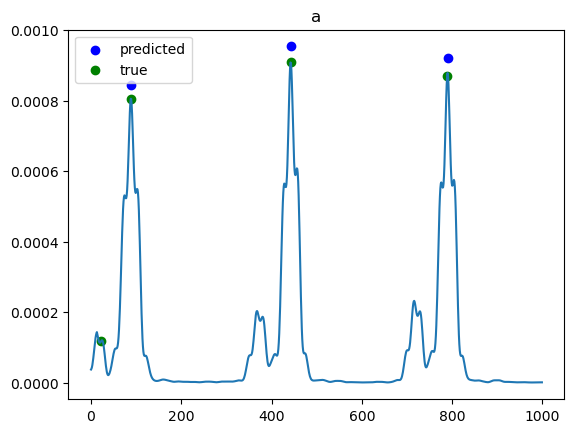

In [37]:
mini = 0
maxi = 1000
print_signal_qrs(cleaned_ecg[mini:maxi], 
                 [a - mini for a in qrs_indices if a < maxi and a > mini], 
                 [a - mini for a in QRS if a < maxi and a > mini], )

In [32]:
def print_signal_qrs(signal, qrs, true_qrs, mini = 0, maxi = 1, description = "a", other_list = []):
    if maxi == 1:
        maxi = len(signal)
    cut_qrs = [a - mini for a in qrs if a < maxi and a > mini]
    true_cut_qrs = [a - mini for a in true_qrs if a < maxi and a > mini]
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal[mini:maxi])
    plt.scatter(cut_qrs , [signal[i] * 1.05 for i in cut_qrs ], color='blue', label = 'predicted')
    plt.scatter(true_cut_qrs , [signal[i] for i in true_cut_qrs ], color='green', label = 'true')
    if other_list != []:
        plt.plot(other_list)
    plt.title(label= description)
    plt.legend()
    plt.show()

In [77]:
np.diff(QRS[1:Y+1])

NameError: name 'Y' is not defined

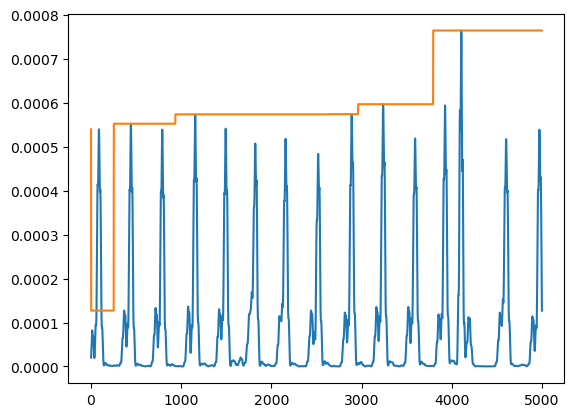

In [44]:
plt.figure()
plt.plot(cleaned_ecg[:5000])
plt.plot(list_seuil[:5000])
plt.show()

signal de longueur: 4000


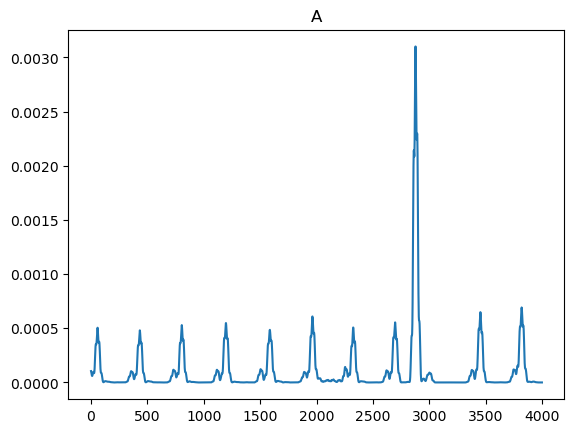

In [68]:
print_signal(cleaned_ecg[8000:12000])

signal de longueur: 650000


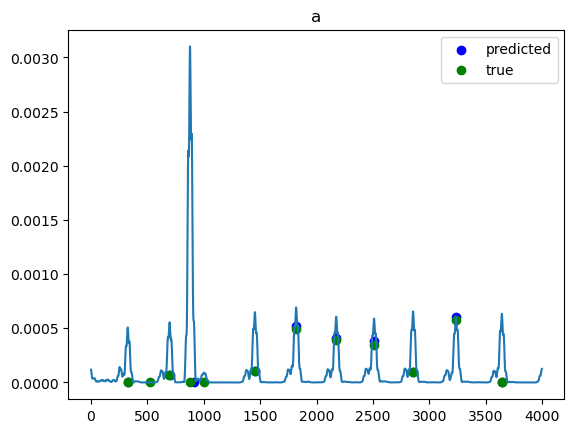

In [57]:
print_signal_qrs(cleaned_ecg, 
                 qrs_indices, 
                 QRS,
                 mini = 10000,
                 maxi = 14000)

In [28]:
def print_signal_qrs(signal, qrs, true_qrs, mini = 0, maxi = 1, description = "a"):
    if maxi == 1:
        maxi = len(signal)
    cut_qrs = [a - mini for a in qrs if a < maxi and a > mini]
    true_cut_qrs = [a - mini for a in true_qrs if a < maxi and a > mini]
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal[mini:maxi])
    plt.scatter(cut_qrs , [signal[i] * 1.05 for i in cut_qrs ], color='blue', label = 'predicted')
    plt.scatter(true_cut_qrs , [signal[i] for i in true_cut_qrs ], color='green', label = 'true')
    plt.title(label= description)
    plt.legend()
    plt.show()

In [10]:
if i < length - start:
                    M_VAL = np.max(cleaned_ecg[i - start:i+start])
                    SPK = make_SPK(M_VAL)
                    NPK = make_NPK(SPK)
                    SEUIL = calcul_seuil(SPK, NPK)

In [74]:
def seuil_dynamique(cleaned_ecg, fs):
    interval_max = 1.111*fs
    RR_interval = 9999
    start = 300 # fs * 3

    qrs_indices = [np.argmax(cleaned_ecg[:start])]
    sous_groupe = []

    A = int(fs//10)
    last_peak = 0

    M_VAL = np.max(cleaned_ecg[:start])
    SPK = make_SPK(M_VAL)
    NPK = make_NPK(SPK)
    SEUIL = calcul_seuil(SPK, NPK)
    list_seuil = []

    prctg = 0.4
    limite_suite = int(fs*0.15)
    i = qrs_indices[-1] + limite_suite
    last_peak = qrs_indices[-1]
    checkpoint = 0
    window_max = 250
    while i < len(cleaned_ecg[:]):
        #list_seuil.append(SEUIL)
        if cleaned_ecg[i] < M_VAL * 0.5:
            M_VAL = cleaned_ecg[last_peak]
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)

        if cleaned_ecg[i] >= SEUIL:
            M_VAL = max(cleaned_ecg[i:i+window_max])
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)

            last_peak = i + np.argmax(cleaned_ecg[i:i+window_max])
            qrs_indices.append(last_peak)

            RR_interval = calcul_AVE_RR(qrs_indices[-10:])
            list_seuil.extend([SEUIL] * (np.argmax(cleaned_ecg[i:i+window_max]) +  limite_suite))      

            i = last_peak +  limite_suite # int(RR_interval * prctg) #

        elif (i - last_peak >= interval_max or i - last_peak >= RR_interval*1.5) and i - checkpoint >= 200:
            temp_seuil = calcul_seuil(SPK/2, make_NPK(SPK/2))
            #print(f"{last_peak}: C  // i = {i}")
            for j in range(last_peak + limite_suite, i):
                if cleaned_ecg[j] >= temp_seuil:
                    last_peak = i + np.argmax(cleaned_ecg[i:i+window_max])
                    qrs_indices.append(last_peak)

                    RR_interval = calcul_AVE_RR(qrs_indices[-10:])
                    list_seuil.extend([SEUIL] * (np.argmax(cleaned_ecg[i:i+window_max]) +  limite_suite)  )  
                    i = last_peak +  limite_suite # int(RR_interval * prctg) #
                    break
                    
            checkpoint = i
        i += 1  
    return qrs_indices, list_seuil

qrs_indices, list_seuil = seuil_dynamique(cleaned_ecg, fs)
perf(QRS, qrs_indices, 36)

TP = 1762, FP = 91, FN = 91, F1_score = 0.9508904479222882


In [ ]:
def seuil_dynamique(sig, fs):

    cleaned_ecg = preprocess_ecg(sig, fs)

    interval_max = 1.111*fs
    RR_interval = 9999
    start = 800 # fs * 3

    qrs_indices = [np.argmax(cleaned_ecg[:start])]
    last_peak = 0

    M_VAL = np.max(cleaned_ecg[:start])
    SPK = make_SPK(M_VAL)
    NPK = make_NPK(SPK)
    SEUIL = calcul_seuil(SPK, NPK)
        
    prctg = 0.4
    limite_suite = int(fs*0.15)
    i = qrs_indices[-1] + limite_suite
    last_peak = qrs_indices[-1]
    while i < len(cleaned_ecg):
        if cleaned_ecg[i] < M_VAL * 0.5:
            last_peak = i + np.argmax(cleaned_ecg[i:i+fs])
            
            M_VAL = cleaned_ecg[last_peak]
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)
            
            RR_interval = calcul_AVE_RR(qrs_indices[-10:])
            qrs_indices.append(last_peak)
            i = last_peak +  limite_suite # int(RR_interval * prctg) #
            
        elif cleaned_ecg[i] >= SEUIL:
            M_VAL = max(cleaned_ecg[i:i+100])
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)
            
            last_peak = i + np.argmax(cleaned_ecg[i:i+limite_suite])
            qrs_indices.append(last_peak)
            
            RR_interval = int((qrs_indices[-2] - qrs_indices[-3])*prctg)
            #RR_interval = calcul_AVE_RR(qrs_indices[-10:])
            i = last_peak +  limite_suite # int(RR_interval * prctg) #
            
            """if len(qrs_indices) > 2:
                RR_interval = int((qrs_indices[-2] - qrs_indices[-3])*prctg) # calcul_AVE_RR(qrs_indices[-10:])
                i = v + int((qrs_indices[-2] - qrs_indices[-3])*prctg)"""        
                
        elif len(qrs_indices) > 3 and (i - last_peak >= interval_max or i - last_peak >= RR_interval):
            temp_seuil = calcul_seuil(SPK/2, make_NPK(SPK/2))
            for j in range(last_peak + limite_suite, i):
                if cleaned_ecg[j] >= temp_seuil:
                    last_peak = np.argmax(cleaned_ecg[i:i+100])
                    qrs_indices.append(last_peak)
                    RR_interval = int((qrs_indices[-2] - qrs_indices[-3])*prctg) # calcul_AVE_RR(qrs_indices[-10:]) # int((qrs_indices[-2] - qrs_indices[-3])*prctg) # calcul_AVE_RR(qrs_indices[-10:])"""
        i += 1    
    
    return qrs_indices